Importing plotly failed. Interactive plots will not work.


Text(0.5, 1.0, 'Test')

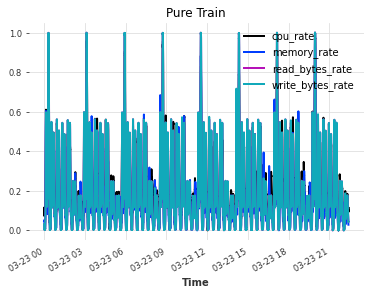

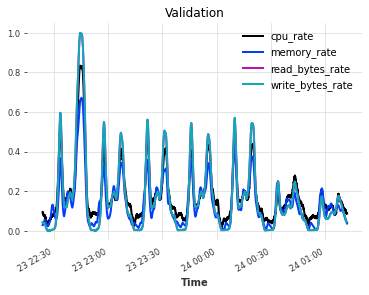

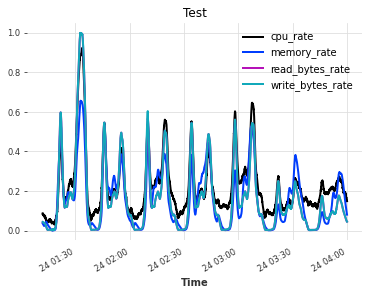

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/cit/lib/"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)

import sys
sys.path.append("/home/jupyter-babakesistani/adaptive-monitoring-nn/")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt
# import tsaug
# import ray
# from ray import tune

from matplotlib.pyplot import figure

dl =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/cpu_memory_disk_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-03-23 00:00:00")
scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_train = 8*scaled_one_week
idx_val = 9*scaled_one_week
train = dl.series_scaled[:idx_train]
val = dl.series_scaled[idx_train:idx_val]
test = dl.series_scaled[idx_val:-1]
    
train.plot()
plt.title("Pure Train")

val.plot(new_plot=True)
plt.title("Validation")

test.plot(new_plot=True)
plt.title("Test")

In [2]:
def day_of_week(idxs):
    days = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) // (24*60)) % 7
    encoders = []
    for day in days:
        if day == 0:
            encoders.append(1)
        elif day == 1 or day == 2 or day == 3 or day == 4: 
            encoders.append(2)
        elif day == 5 or day == 6:
            encoders.append(3)
    return encoders

def minute_of_day(idxs):    
    minute_of_day = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) % (24*60))
    return minute_of_day


In [3]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

dl_retrain =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/23_may_shiftedd.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-04-20 00:00:00")
retrain_df = dl_retrain.darts_df
train = TimeSeries.from_dataframe(dl.darts_df, dl.time_col, dl.target_cols)
train_retrain = TimeSeries.from_dataframe(dl_retrain.darts_df, dl_retrain.time_col, dl_retrain.target_cols)[:scaled_one_week]
concat_train = train.concatenate(train_retrain,ignore_time_axes=True)

concat_train_scaler = Scaler()
concat_train_scaled = concat_train_scaler.fit_transform(concat_train)

train_scaled = concat_train_scaled[:-scaled_one_week]
train_retrain_scaled = concat_train_scaled[-scaled_one_week:]
train_retrain_scaled = dl.shift_series_to(train_retrain_scaled, "2022-04-20 00:00:00")


In [ ]:
model = BlockRNNModel.load_model("retrained_scaled.pth.tar")

In [41]:
model.save_model("retrained_scaled.pth.tar")

In [45]:
test_retrain = TimeSeries.from_dataframe(dl_retrain.darts_df, dl_retrain.time_col, dl_retrain.target_cols)[scaled_one_week:-1]

In [46]:
test_retrain_scaled = concat_train_scaler.transform(test_retrain)

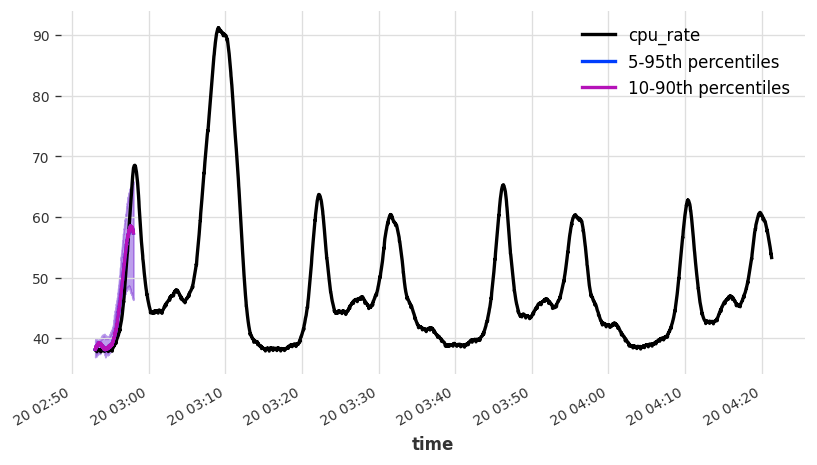

<Figure size 960x480 with 0 Axes>

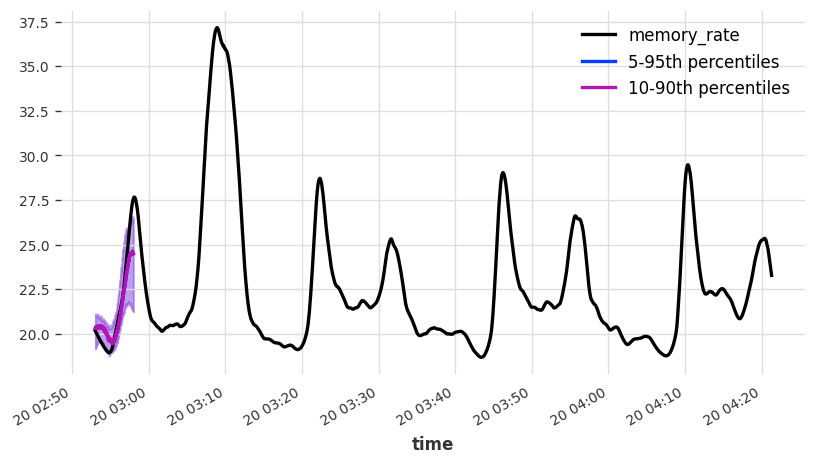

<Figure size 960x480 with 0 Axes>

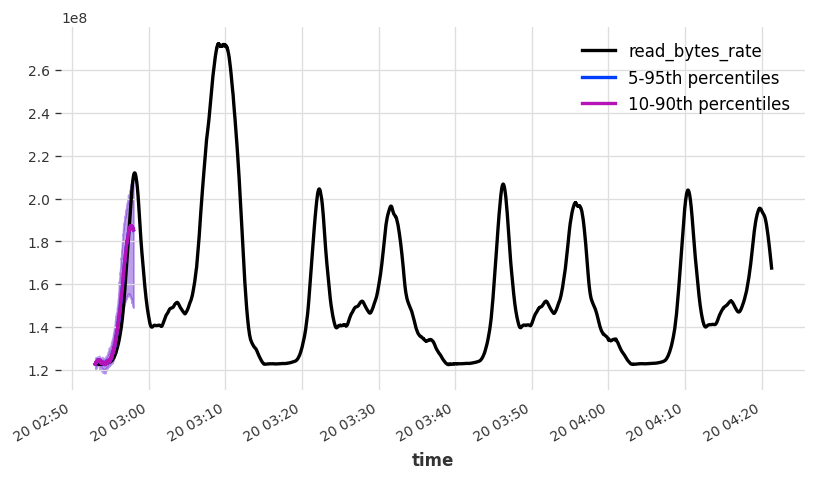

<Figure size 960x480 with 0 Axes>

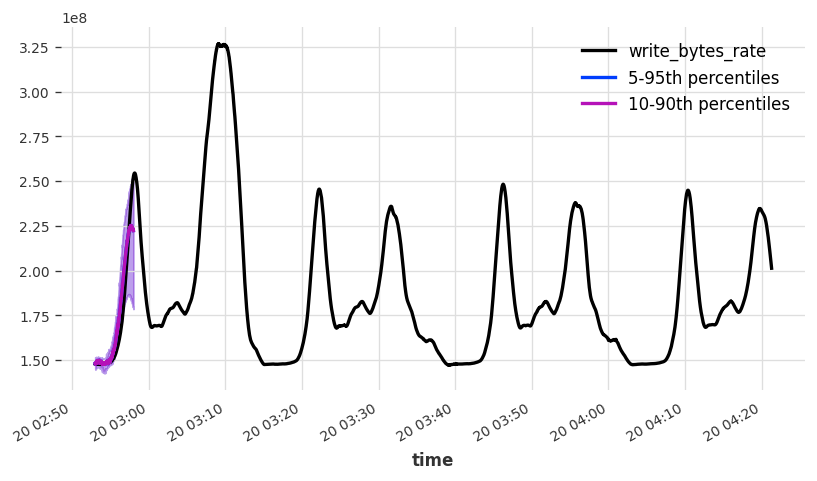

<Figure size 960x480 with 0 Axes>

In [50]:
test_plot = test_retrain_scaled
cut_off = 300
pred_len = 300
pred = model.predict(series=test_plot[:cut_off], n=pred_len, num_samples=500)
pred = concat_train_scaler.inverse_transform(pred)
test_back =concat_train_scaler.inverse_transform(test_plot)

for i in range(pred.n_components):
    figure(figsize=(8, 4), dpi=120)
    test_back[cut_off:cut_off+pred_len+5000].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.01, high_quantile=0.99, label="5-95th percentiles")
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9,  label="10-90th percentiles")
    figure(figsize=(8, 4), dpi=120)
#     plt.savefig(str(i))
    plt.show()

In [7]:
model_raw = BlockRNNModel.load_from_checkpoint("LSTM_23march_stopper",work_dir="../Training/logs/lstm_23march_stopper/", best=True)

[2022-06-17 14:34:51,063] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_19.pth.tar
[2022-06-17 14:34:51,063] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_19.pth.tar
/home/jupyter-babakesistani/.conda/envs/cit/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


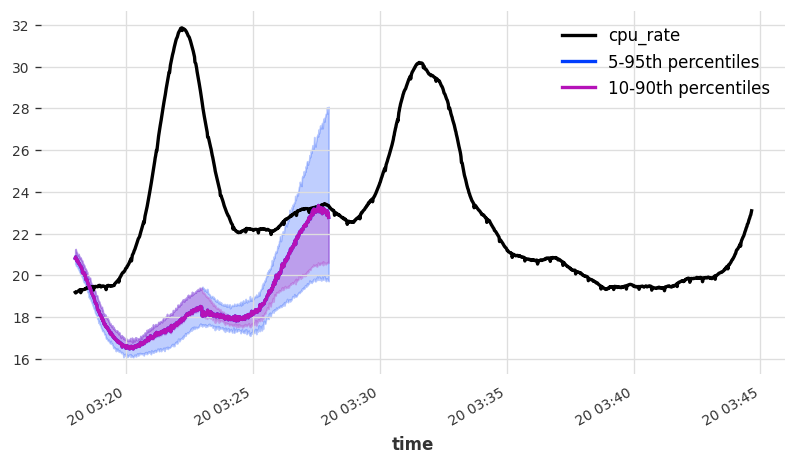

<Figure size 960x480 with 0 Axes>

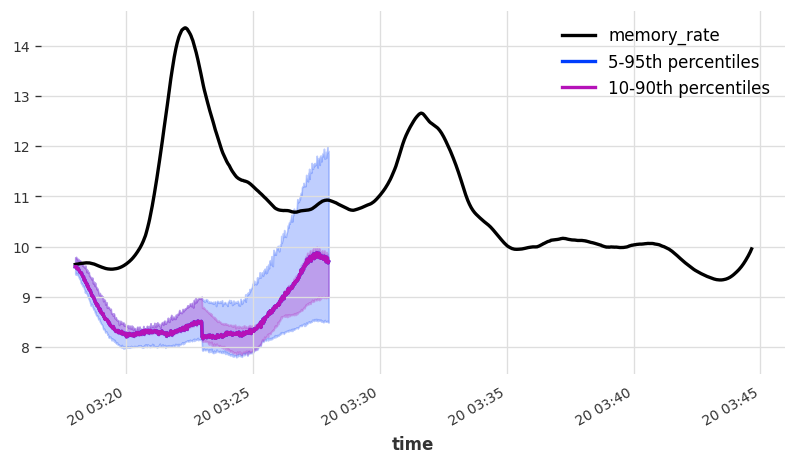

<Figure size 960x480 with 0 Axes>

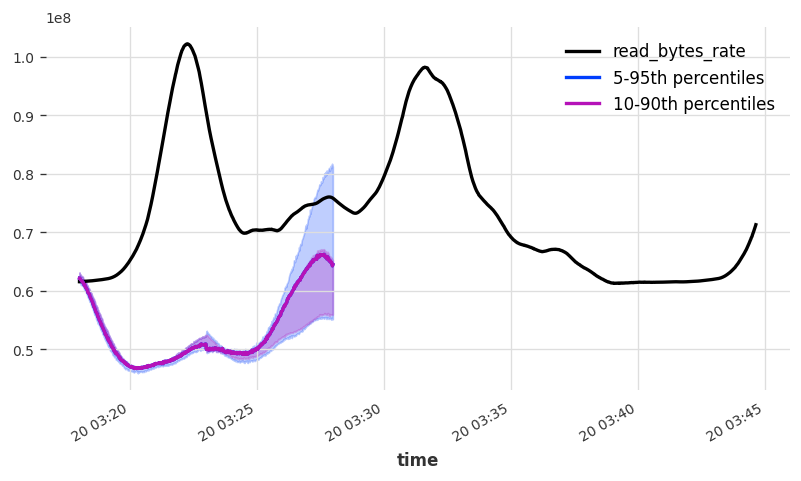

<Figure size 960x480 with 0 Axes>

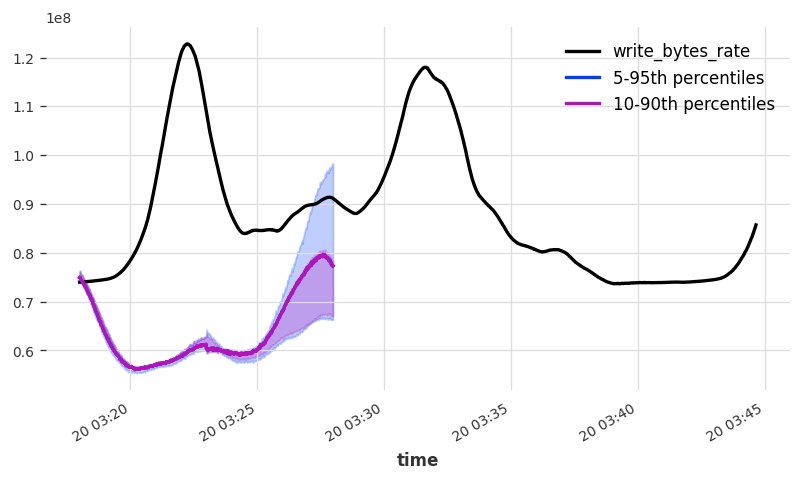

<Figure size 960x480 with 0 Axes>

In [9]:
test_plot = val_retrain
cut_off = 1800
pred_len = 600
pred = model_raw.predict(series=test_plot[:cut_off], n=pred_len, num_samples=500)
pred = dl.scaler.inverse_transform(pred)
test_back = dl.scaler.inverse_transform(test_plot)

for i in range(pred.n_components):
    figure(figsize=(8, 4), dpi=120)
    test_back[cut_off:cut_off+pred_len+1000].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.01, high_quantile=0.99, label="5-95th percentiles")
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9,  label="10-90th percentiles")
    figure(figsize=(8, 4), dpi=120)
#     plt.savefig(str(i))
    plt.show()